# DSMCER Notebook 10 - Non-Supervised Learning

1. Unsupervised Learning
    1. _Poll_: What have we seen that was unsupervised?
    2. Dimensionality reduction
    3. K-Means
    4. _Poll_: Where is the centroid?
    5. _Exercise_: what K is best
2. Rienforcement Learning

In [ ]:
import requests
import random
import io
import time
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.gaussian_process

import rdkit.Chem
import rdkit.Chem.Descriptors
import rdkit.Chem.rdMolDescriptors
import rdkit.ML.Descriptors.MoleculeDescriptors

# ! NEW
import sklearn.cluster
import sklearn.inspection

***
***

## 1. Unsupervised Clustering

<font size=5><center>The goal of unsupervised learning is to __map the data to a new data space that is more interpretable or extracts information__.

<font size=4> Recall that the word "unsupervised" comes because we have no labels:

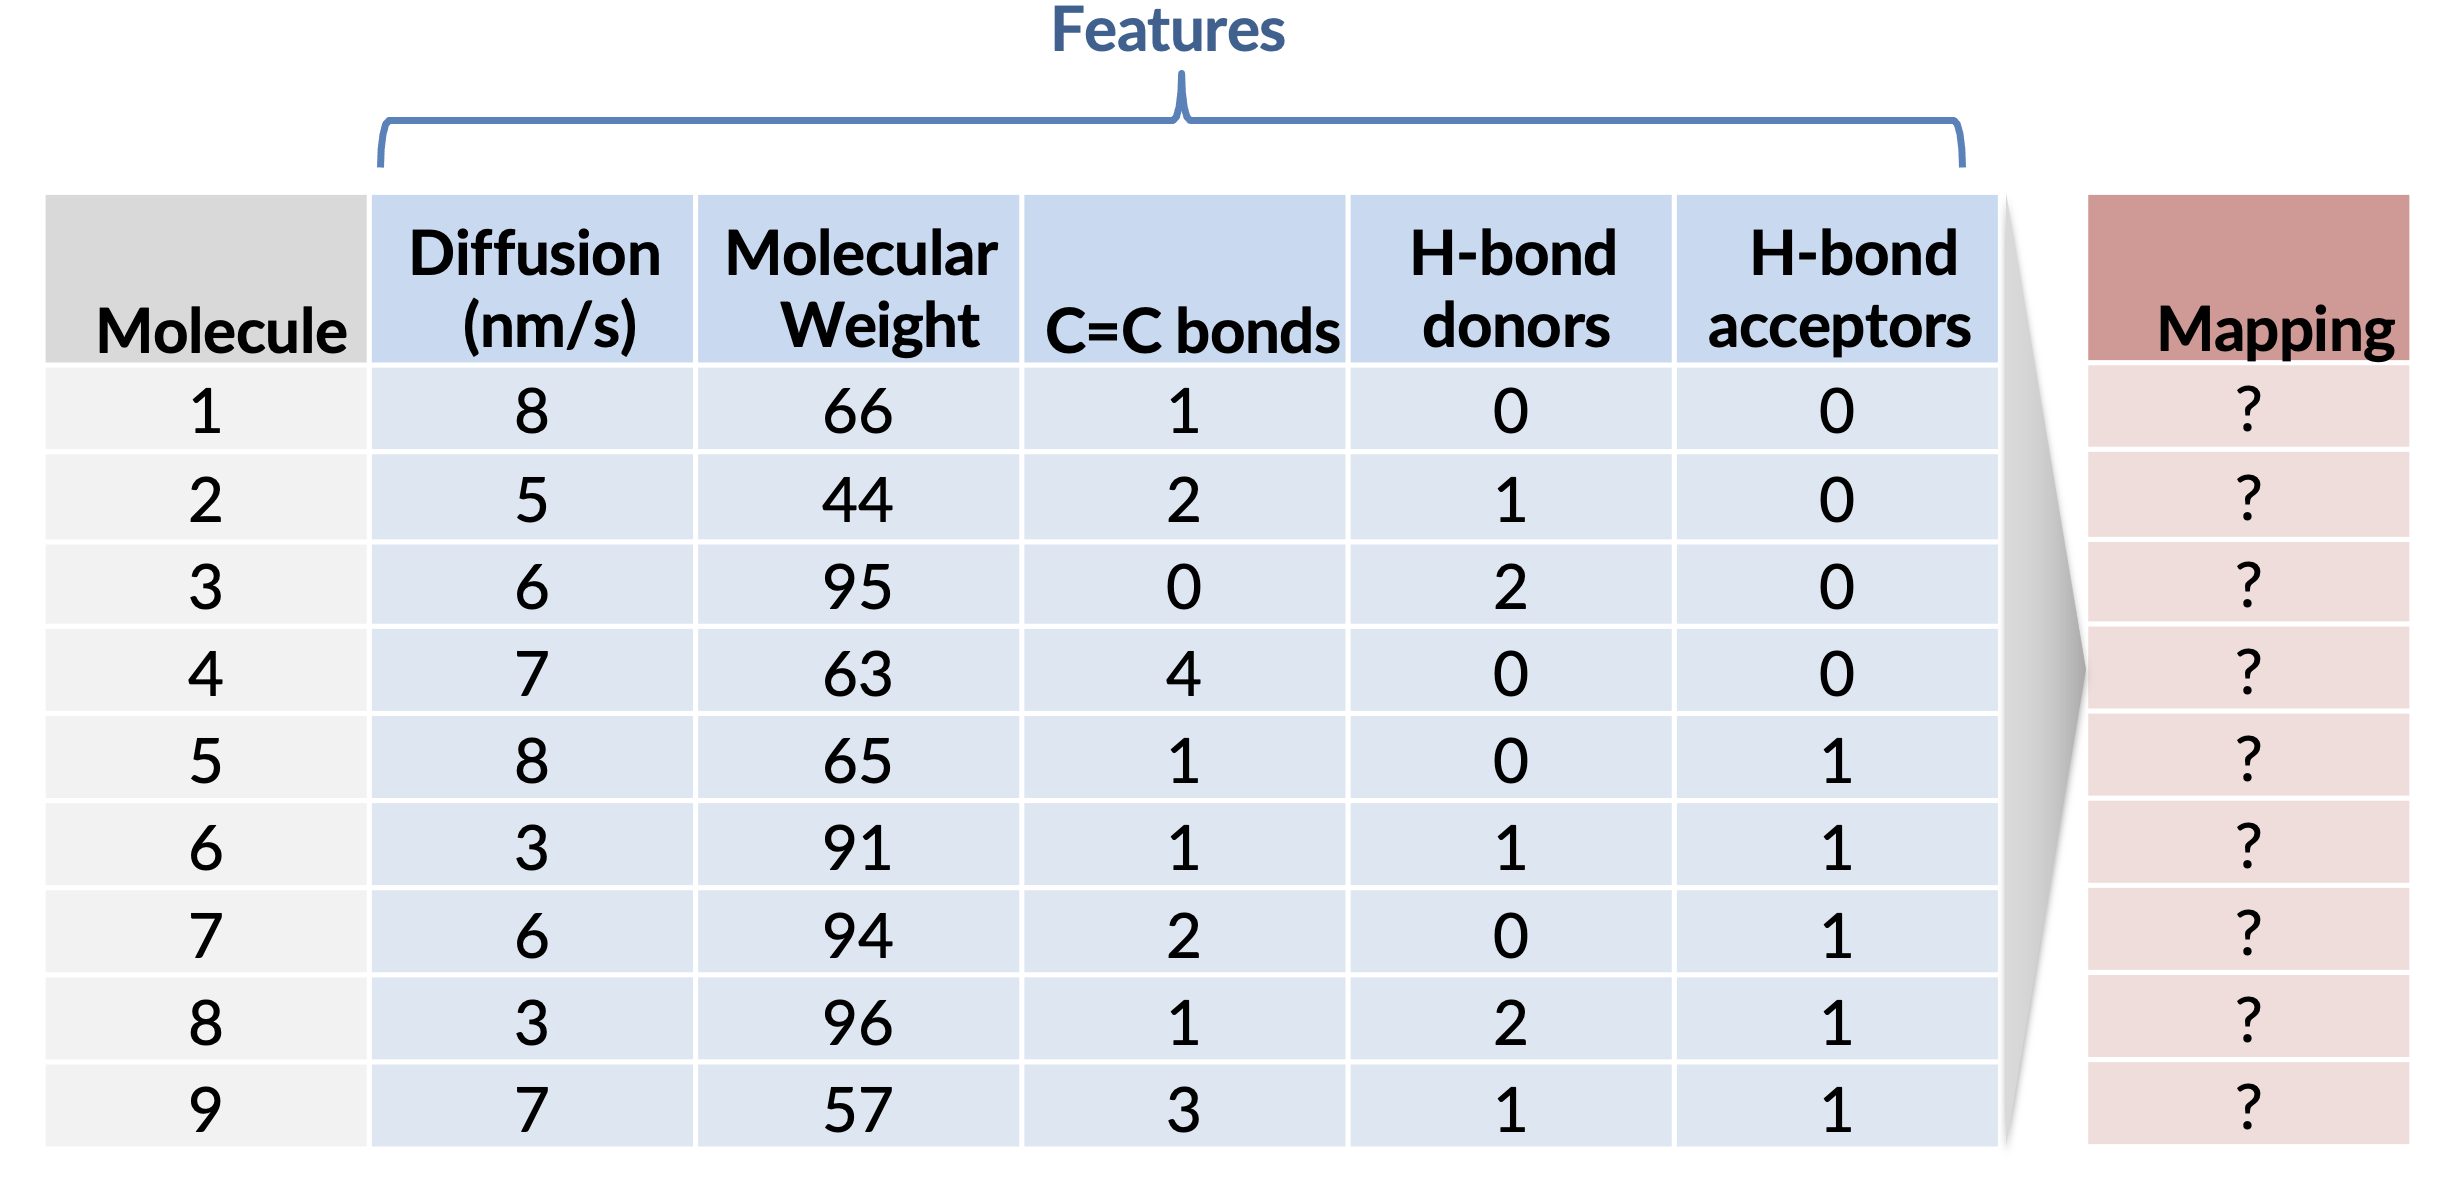

### A. _Poll_: What algorithm have we explored in class that is an unsupervised method?
***

### B. Dimensionality reduction

<font size=4> __Other methods for dimensionality reduction that do not make the linear feature relationship approximation__:
    
- <font size=4> [Multi-dimensional Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) (MDS) Finds a lower dimensional space __that maintains the distances between data__. Basically, rotating and scaling functions are applied to the data to remove dimensions, but preserved the "difference" between data points.
    - <font size=4> Kind of an extension of PCA - it is actually conducting PCA on "similarities" instead of features. A wide range of "similarity" metrics are available. More tunable and generally more useful that PCA alone.
    
- <font size=4> [T-distributed Stochastic Neighbor Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (TSNE) Places data in a lower dimensional space, then iteratively moves them (think spring forces) according to the distances to other points in the original space. 
    - <font size=4> Does not have parameters and thus cannot be extended to new data. Components no longer have a physical meaning, T-SNE is very good at creating visually intepretable low D spaces but should not be used for anything else.

<font size=5><center>In the last notebook we used dimensionality reduction to make cheaper supervised models, but we can also __use it to help us visualize__.

<font size=4> Let's load the breast cancer data:

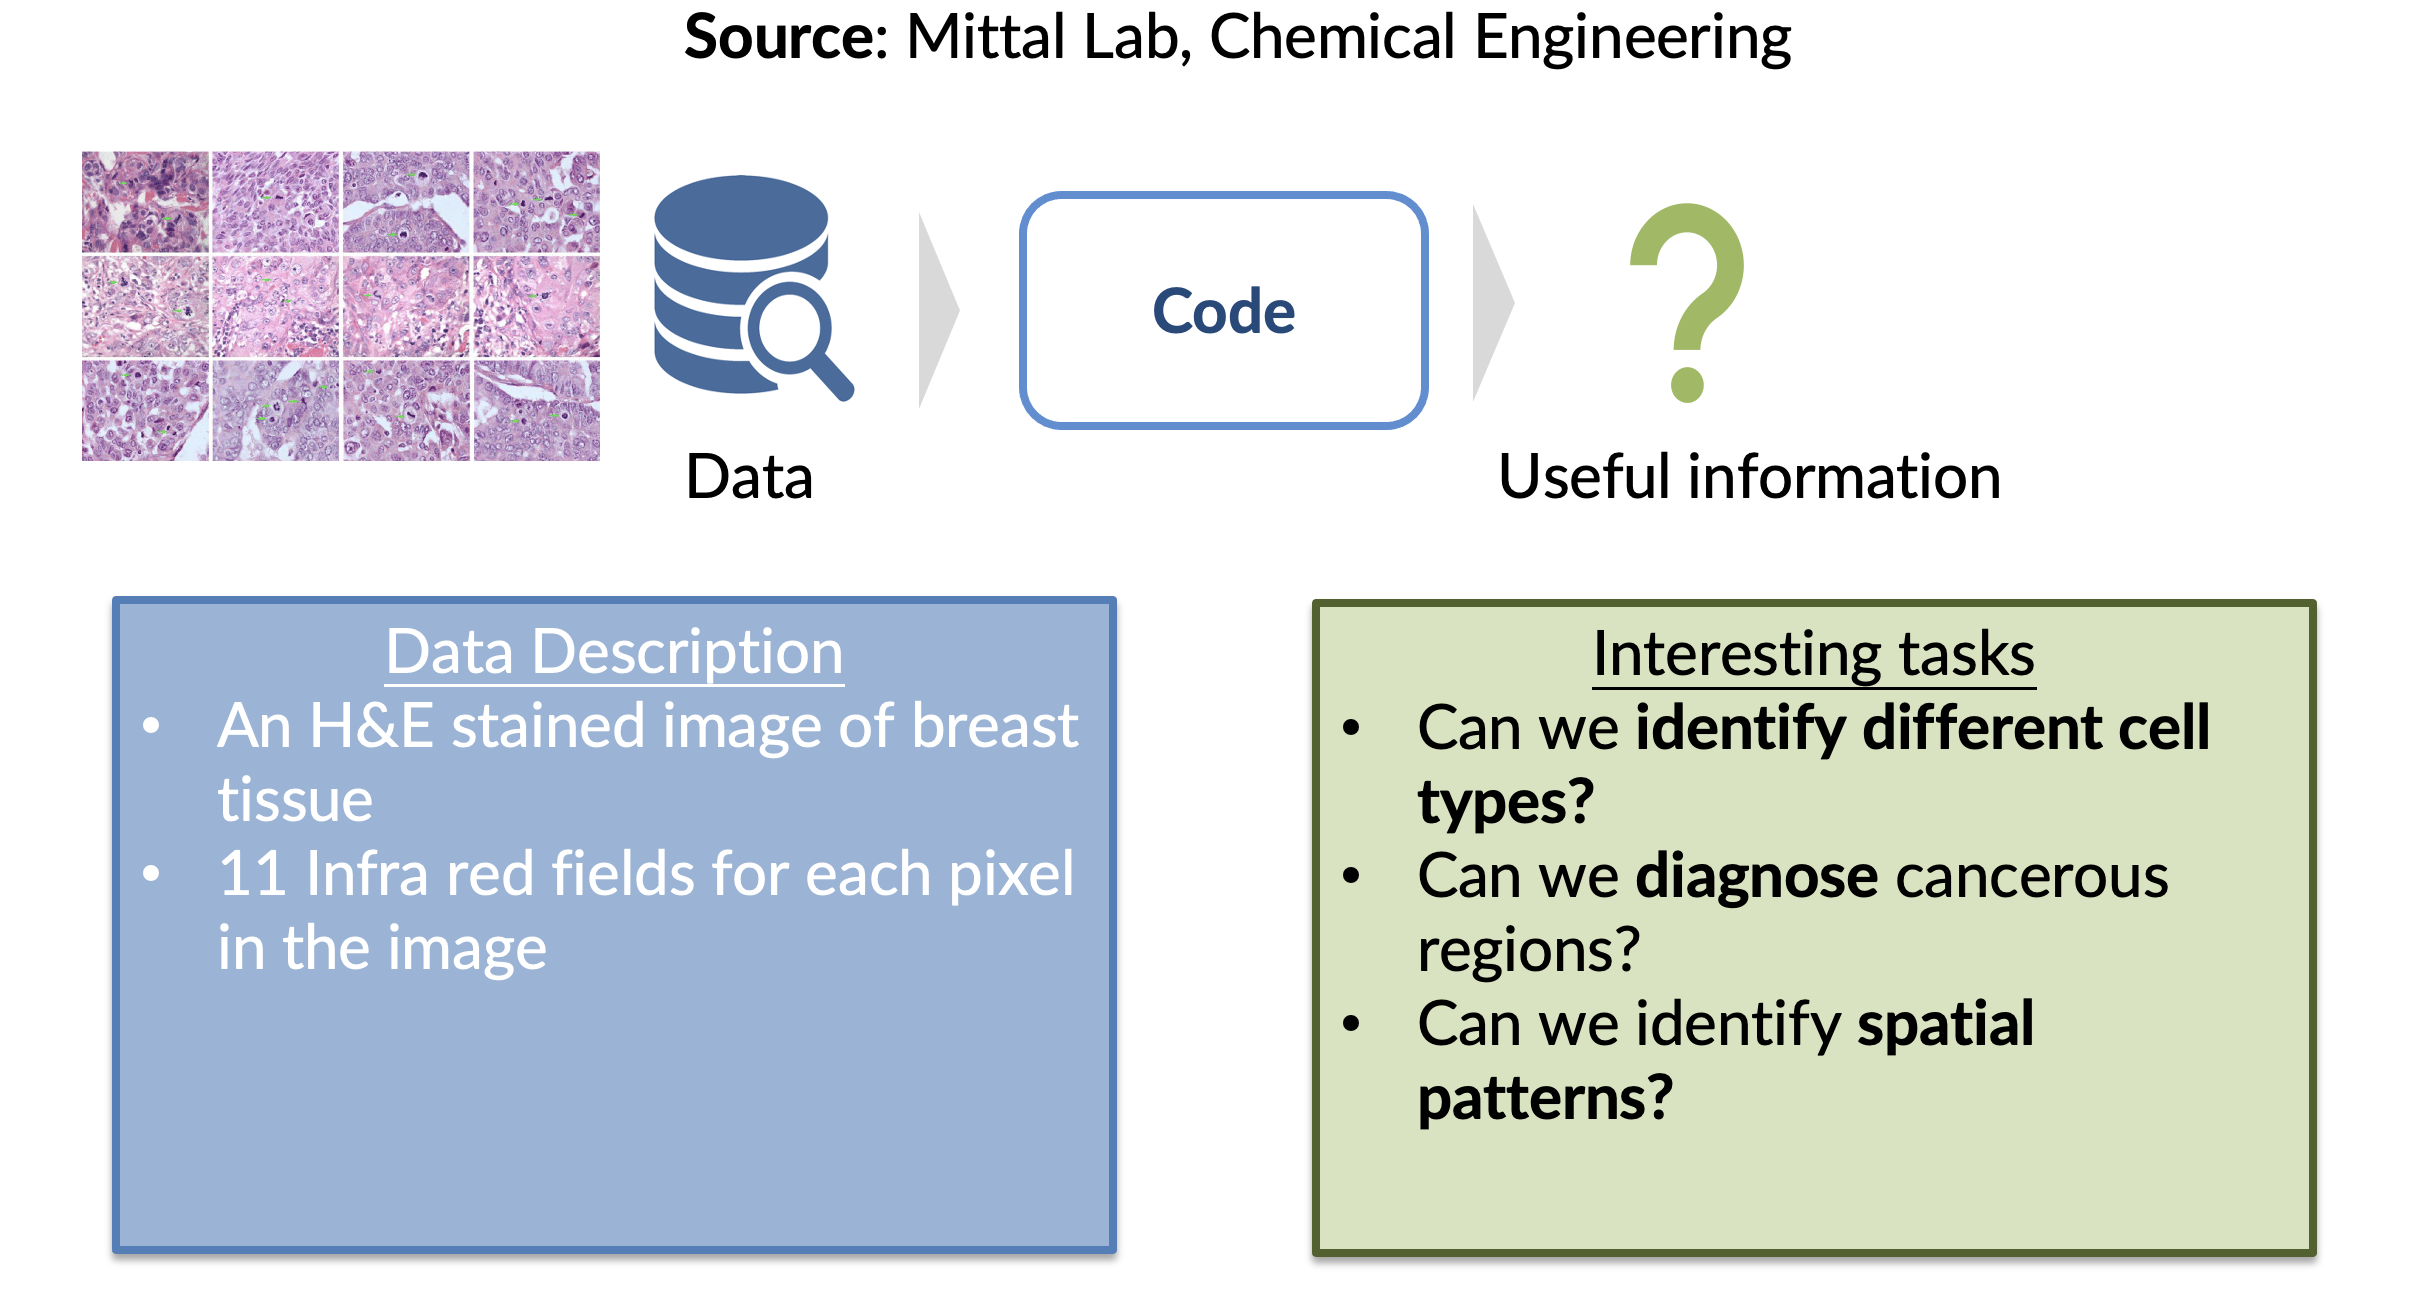

In [ ]:
# here I am downloading and opening a numpy array saved as .npy file
response = requests.get('https://github.com/UWDIRECT/UWDIRECT.github.io/raw/master/datasets/Mittal_BreastImage/breast_IR.npy')
response.raise_for_status()
X = np.load(io.BytesIO(response.content))

In [ ]:
print(f"Shape of array: {X.shape}")

<font size=4> We have 1654x1163 pixels, each with 11 features

In [ ]:
original_pixel_shape = X.shape[:2]

<font size=4> Let's treat each pixel as an example:

In [ ]:
X = X.reshape(-1, X.shape[2])

<font size=4> How could we visualize the data space for all pixels? We have 11 dimensions? Dim reduction to the rescue!

In [ ]:
# always standardize
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
%timeit
# fit the tsne
tsne = sklearn.manifold.TSNE(n_components=2, n_iter=250, init='pca', n_jobs=8, learning_rate='auto')
components = tsne.fit_transform(X)

In [ ]:
# run this instead if T-SNE is taking too long (it is expensive)
pca = sklearn.decomposition.PCA(n_components=2)
components = pca.fit_transform(X)

<font size=4> Let's look at this lower dimensional (2D) space to see if we notice any patterns

In [ ]:
fig, ax = plt.subplots()
components_df = pd.DataFrame(data=components, columns=['PC0', 'PC1'])
sns.kdeplot(components_df.sample(1000), x='PC0', y='PC1', ax=ax)

<font size=5><center>Do not be confused - __the axis here are *not* the pixel axis__ - these axis instead represent two abstract demensions describing what was observed in the IR for th data.

In [ ]:
plt.imshow(components[:,0].reshape(original_pixel_shape))

<font size=5><center>We can see that even just our first pricipal component is clearly related to the tissue structure observed in the pixel. While this is great for visual understanding, __how can we go about actually labeling sections of this image__?

***

### C. K-Means clustering

<font size=4>Clustering is a very common unsupervised task; can we intuit patterns in the data that yield groups?

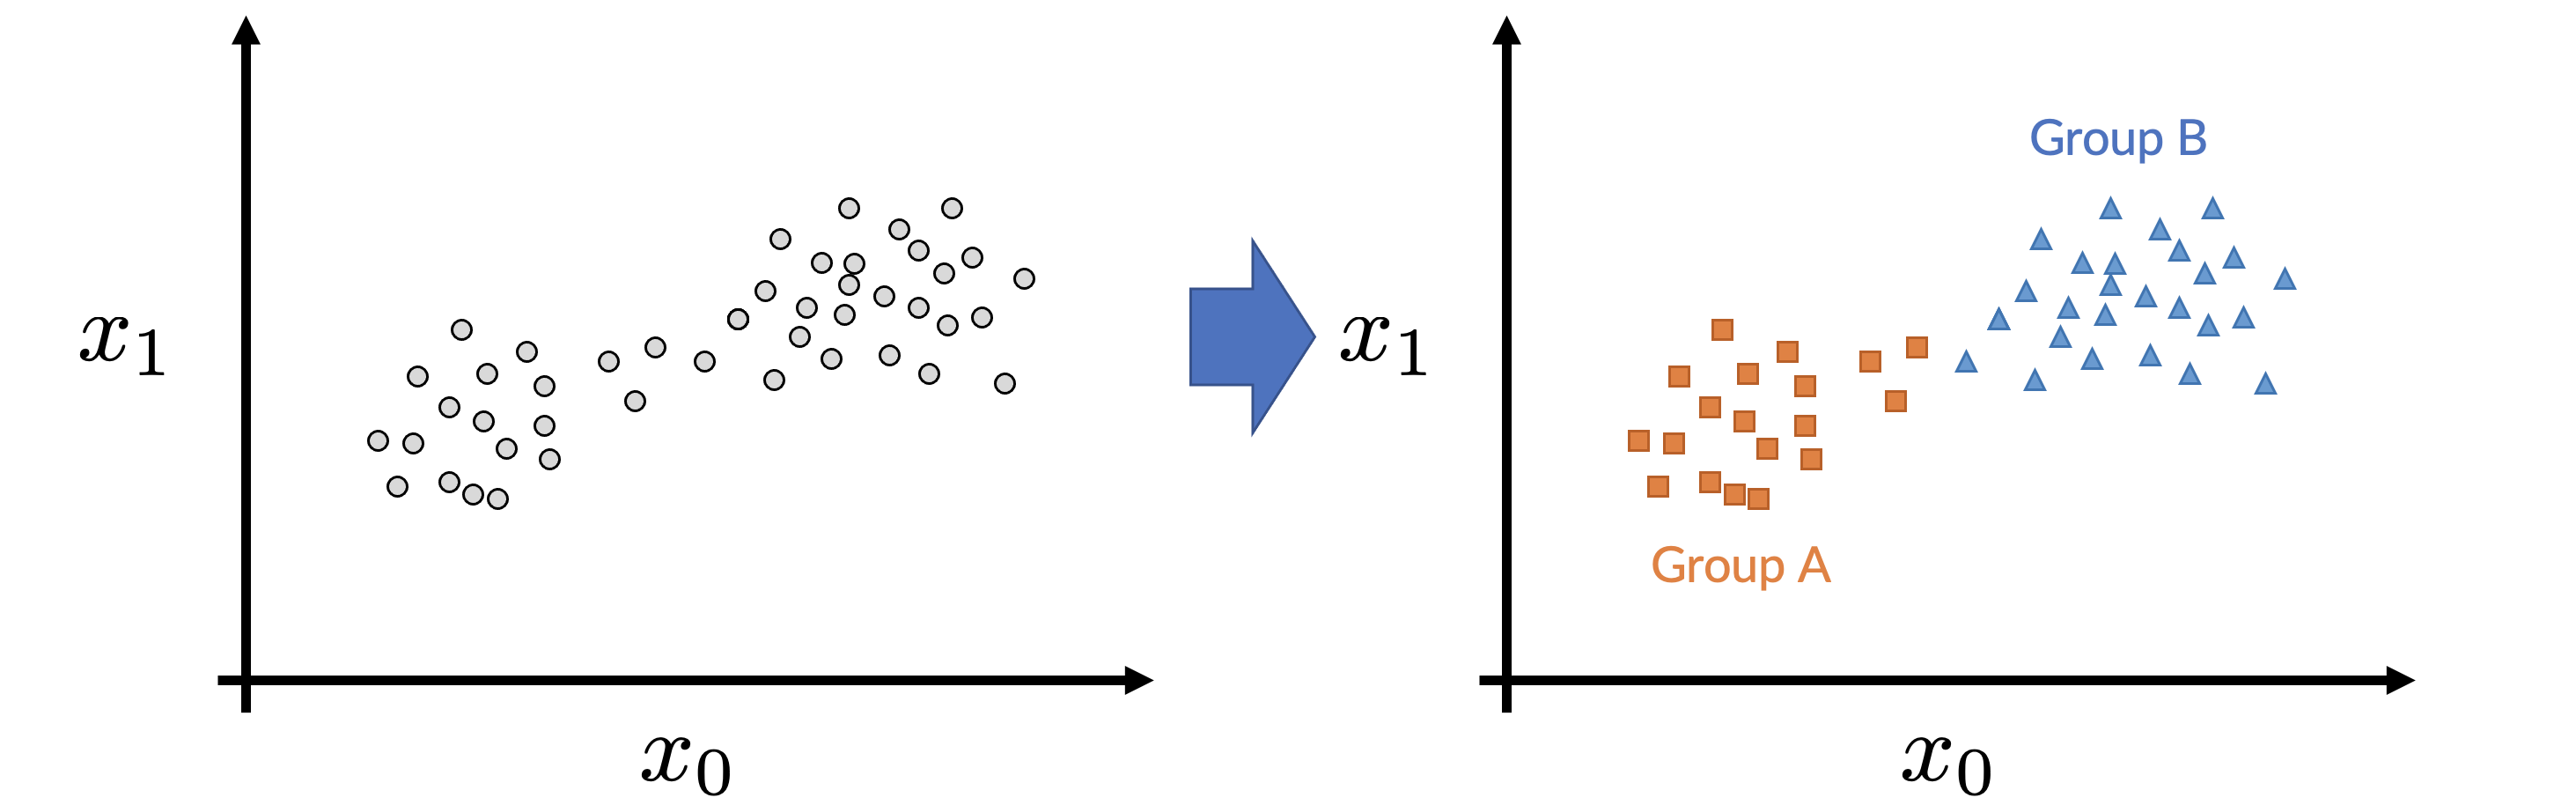


<font size=4>In K-means clustering, we define a desired number of clusters _K_ and assign each observation to one of the clusters.</font>

**Rules:** 
- Each observation must be placed in at least one of the clusters
- No clusters may overlap, each observation can only be placed in a single cluster 
- The goal is to __minimize the variance of observations__ within each of the clusters 


**Algorithm:**

Choose a values for your number of clusters _K_:

- At random select _K_ points from your dataset and assign those to be *centroids*, cluster centers
- Assign each data point to the closest centroid (use the Euclidean distance)
- Re-compute the centroids using the currently assigned clusters
- If a convergence criterion is not met, repeat steps 2 and  3

This algorithm corresponds to solving the problem

$$\underset{C_{1},...,C_{K}}{\text{minimize}}\sum_{j=1}^K\sum_{{\bf x}\in {\bf C}_j}d({\bf x},{\bf m}_j)^2$$

with 

$d({\bf x},{\bf m}_j)$ the Euclidean distance between data point x
and centroid $m_j$, $C_j$ the $j-$th cluster, and $m_j$
is the centroid of cluster $C_j$ i.e. the mean vector of all the
data points in $C_j$


***

### D. _Poll_: Where is the centroid?

1. <font size=4> (0.0, 0.0)

2. <font size=4> (0.0, 0.33)

3. <font size=4> (0.0, 0.5)

4. <font size=4> (0.0, 0.66)

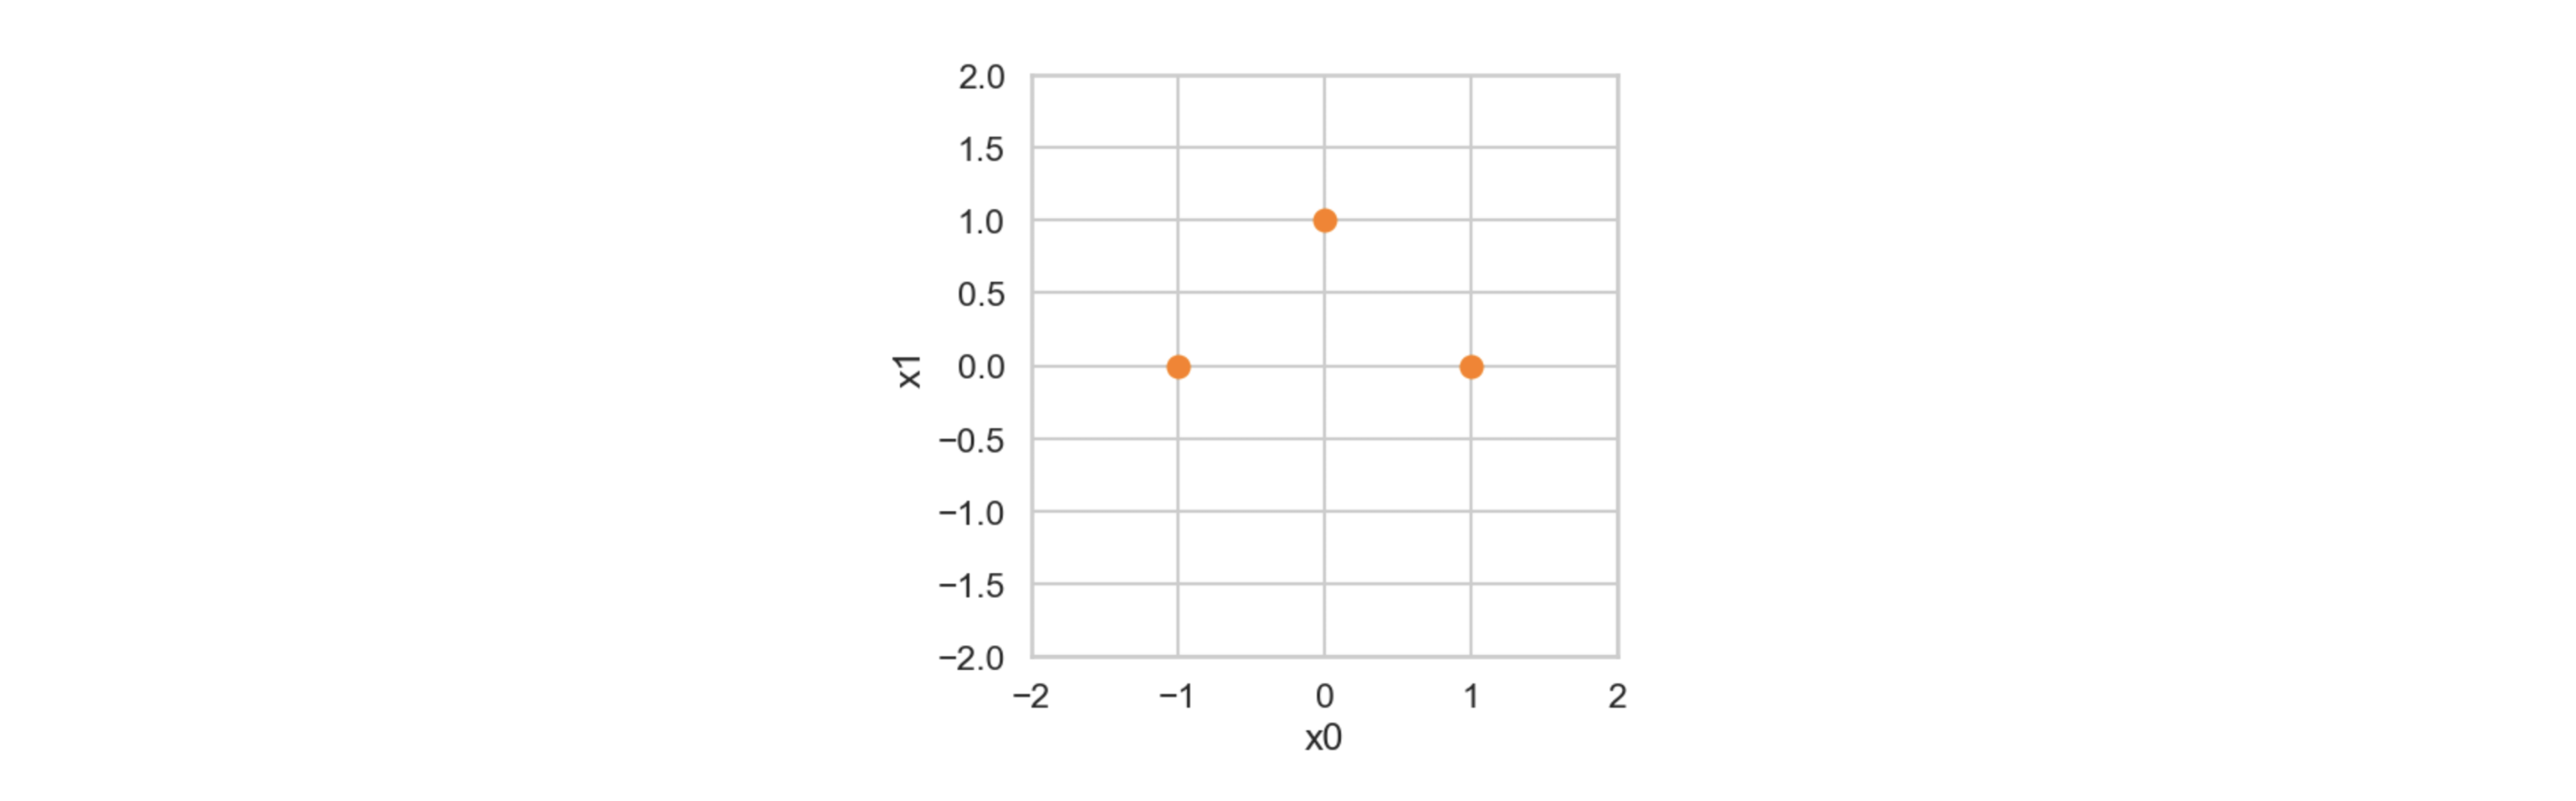

***

In [ ]:
# work with PCA moving forward
pca = sklearn.decomposition.PCA(n_components=2)
components = pca.fit_transform(X)

<font size=4> Let's run K-Means on the infrared data.

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters=5)
kmeans.fit(components.astype('double'))

In [ ]:
centroids = kmeans.cluster_centers_
centroids.shape

In [ ]:
labels = kmeans.predict(components.astype('double'))
pd.value_counts(labels)

<font size=4> The clusters in component space...

In [ ]:
decision_bound = sklearn.inspection.DecisionBoundaryDisplay.from_estimator(
    estimator=kmeans, X=components.astype('double'))

decision_bound.ax_.set_xlabel('PC0')
decision_bound.ax_.set_ylabel('PC1')

# add kde of data over top
components_df = pd.DataFrame(data=components, columns=['PC0', 'PC1'])
sns.kdeplot(components_df.sample(1000), x='PC0', y='PC1', ax=decision_bound.ax_, color='k')

<font size=4> hmm ... should cluster 4 and 5 be different? Let's apply the predicted classes to the pixels and plot the result

In [ ]:
plt.imshow(labels.reshape(original_pixel_shape))

<font size=4> The classes are interspersed together such that one tissue structure has multiple classes. This is probably too much - it would be better if nearly all pixels of a specific tissue structure were labeled the same. __We arbitrarily chose 5 clusters__.

***

<font size=5><center>We observed 3 distinct regions in the T-SNE, and I observe ~3 types of structures in the tissue (anyone have clinical experience can chime in..?)

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters=3)
kmeans.fit(components.astype('double'))

In [ ]:
labels = kmeans.predict(components.astype('double'))

In [ ]:
plt.imshow(labels.reshape(original_pixel_shape))

<font size=4> That's not great either... the tumor registers the same class as the bulk tissue. How can we do this rigourously?

***

<font size=5><center>An example's distance from the centroid indicates its deviation from the average of the cluster. __We want our data to have low distances on averge__, the silhouette score helps us do this.

<font size=4>$$S=\frac{NCD - ICD}{max(ICD, NCD)}$$

<font size=4> Here the "intra cluster distance" is the mean distance of data in a cluster to its cluster centroid, eg. $ICD = \Sigma_i^N\frac{d(x_i,m_i)}{N}$ and the "nearest cluster distance" is the mean distance of data to the nearest cluster that the data point is __not__ assigned to, $NCD = \Sigma_i^N\frac{d(x_i,m_{nearest})}{N}$.
    
<font size=4> __We want this number to be 1.0__ which indicates very good seperation. 0.0 represents cluster overlap, and negative numbers represents misclassification, eg. other clusters are closer than the assigned cluster.

<font size=4> We will also use all of the features instead of just the PCs:

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters=3)
kmeans.fit(X.astype('double'))

<font size=4> Silhouette can be expensive, so let's do it on a sample

In [ ]:
sample = pd.DataFrame(X).sample(2000, random_state=1).values

In [ ]:
sample_labels = kmeans.predict(sample.astype('double'))

In [ ]:
print(f"Silhouette score for 3 clusters: {sklearn.metrics.silhouette_score(sample, sample_labels)}")

### E. _Exercise_: what should K be

<font size=4>Test out values of K from 2 to 10, and compute an estimate of the silhouette score for the whole dataset. Create a plot showing the trend, what value of K would you chose?

## 2. Rienforcement learning

<font size=4>Consider the following scenario. Here, we have a machine learning model the predicts "activity" that we want to be high, and we come into lab to chose one new sample to synthesize. __Which sample should we synthesize?__

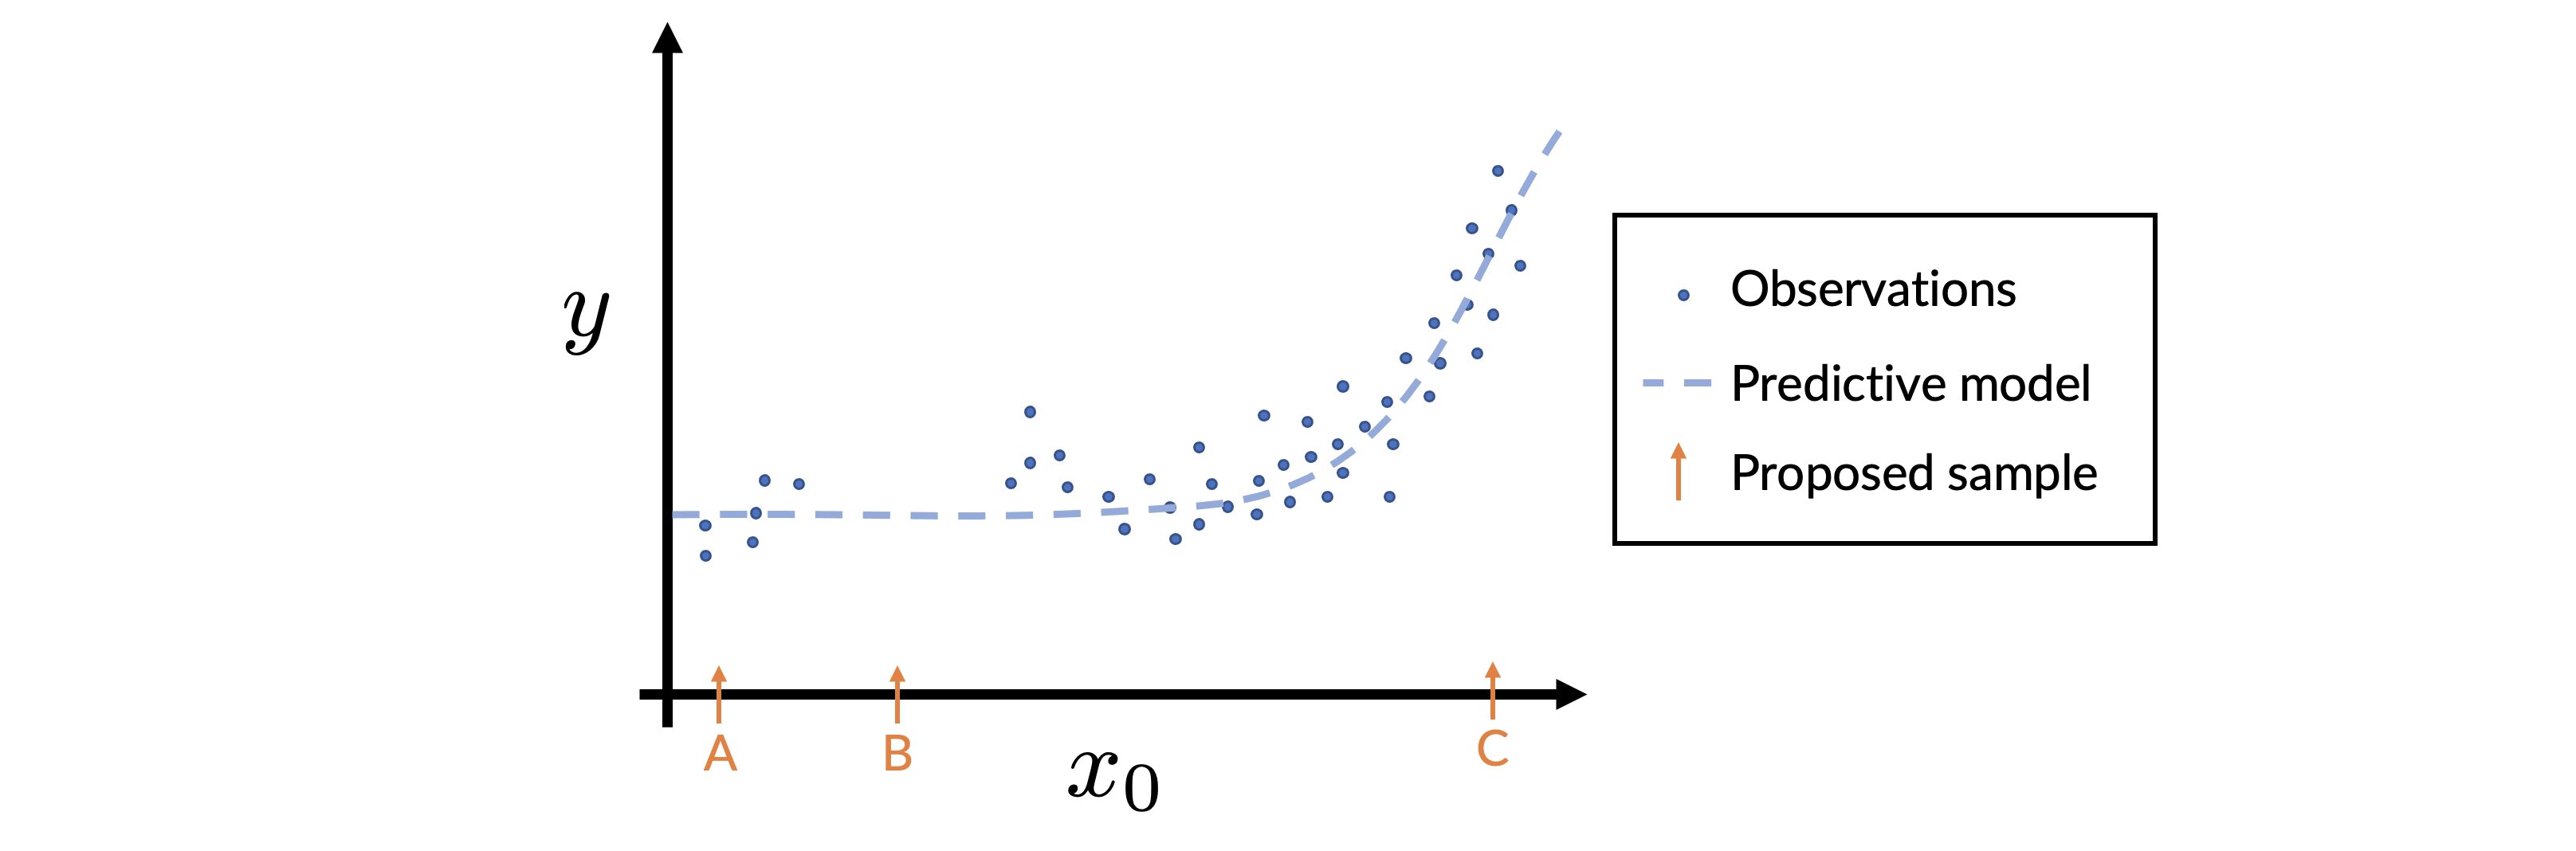

<font size=4> From a supervised perspective, we would chose to spend the resources on __sample C__ because we predict it has the best activity.

<font size=5><center>This method is called __greedy__ because here we are maximizing the "reward" for the next sample we take.

***

<font size=4> The __greedy__ algorithm does not maximize reward *in perpetuity*:

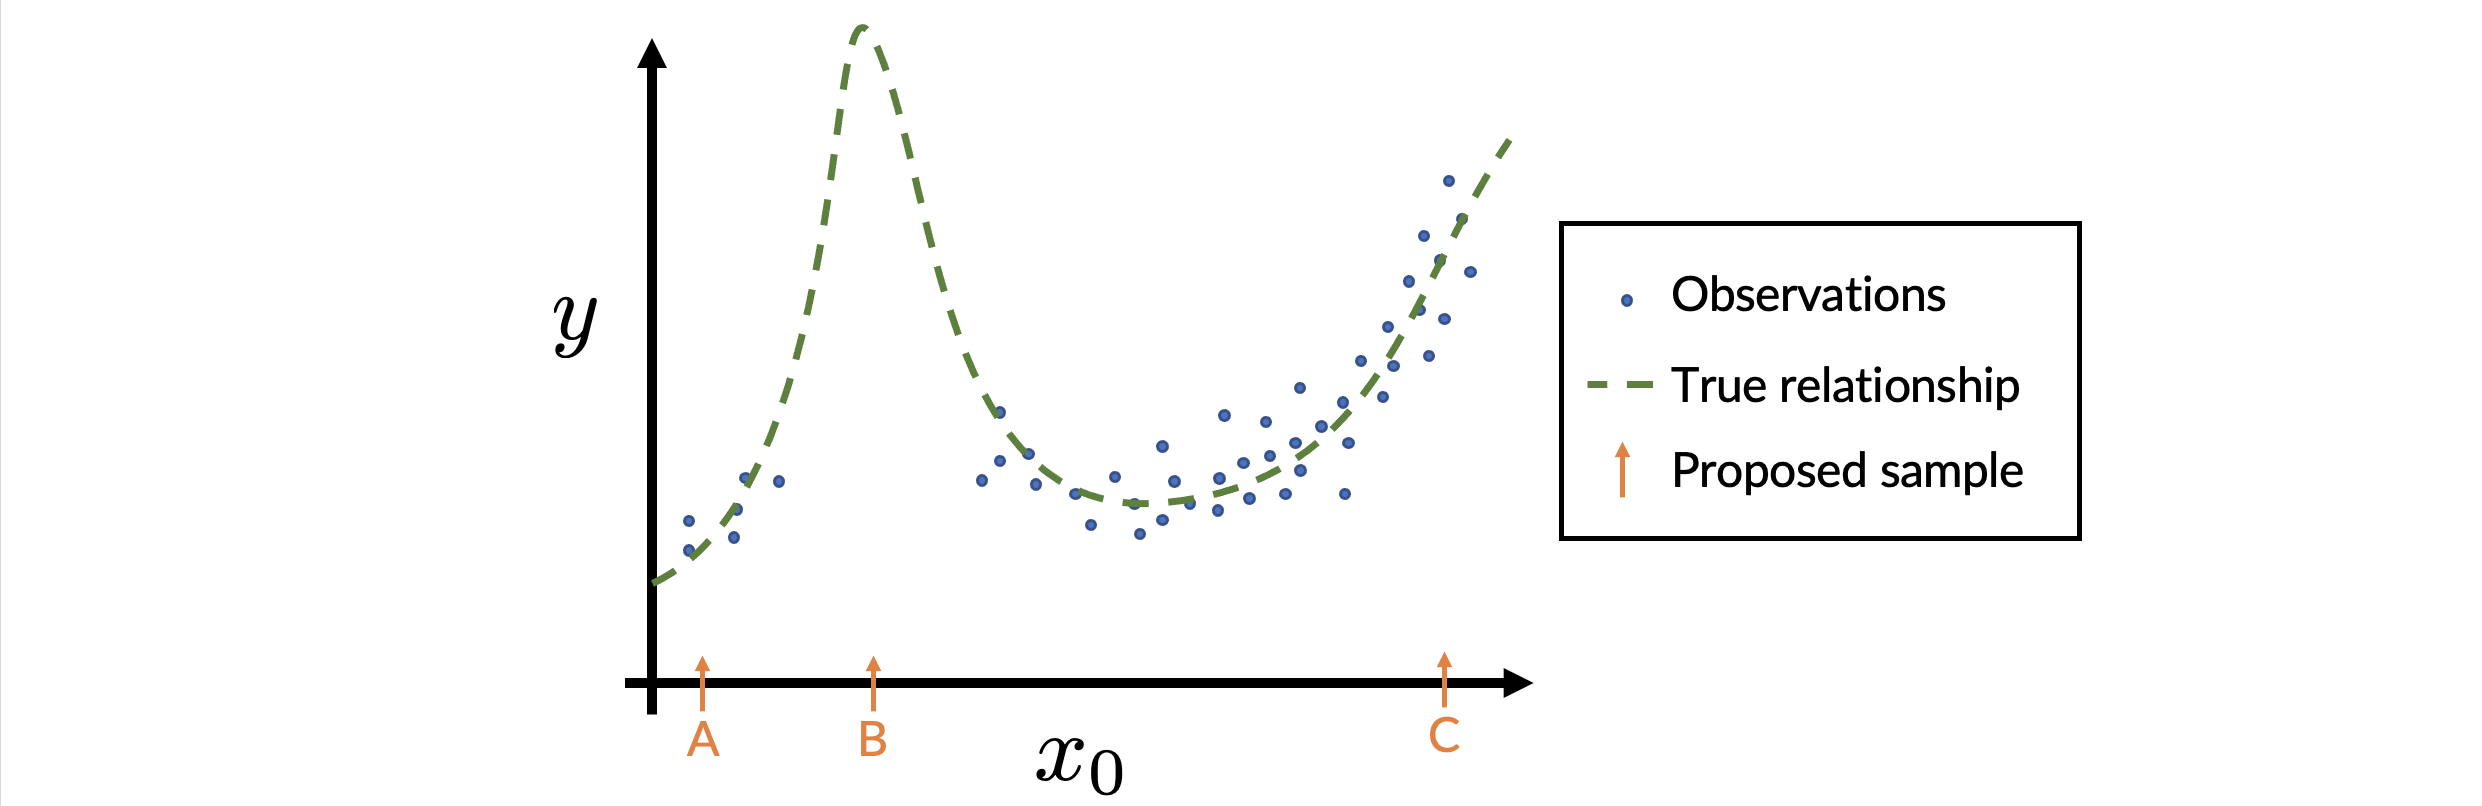

<font size=4> We can see that B would be better, but we would never know that unless we sometimes took samples other than the greedy one.

<font size=5><center>Rienforcement learning seeks to __maximize longterm reward instead of instantaneous reward__.

***

<font size=4> If you plan on taking more data in the future, as opposed to just making predictions __then rienforcement is for you__!

<font size=4> For a rigorous exploration of this topic, consider [CSE 541](https://courses.cs.washington.edu/courses/cse541/), also see this [resource](https://deepsense.ai/what-is-reinforcement-learning-the-complete-guide/). Here we will do something simple to give you the idea.

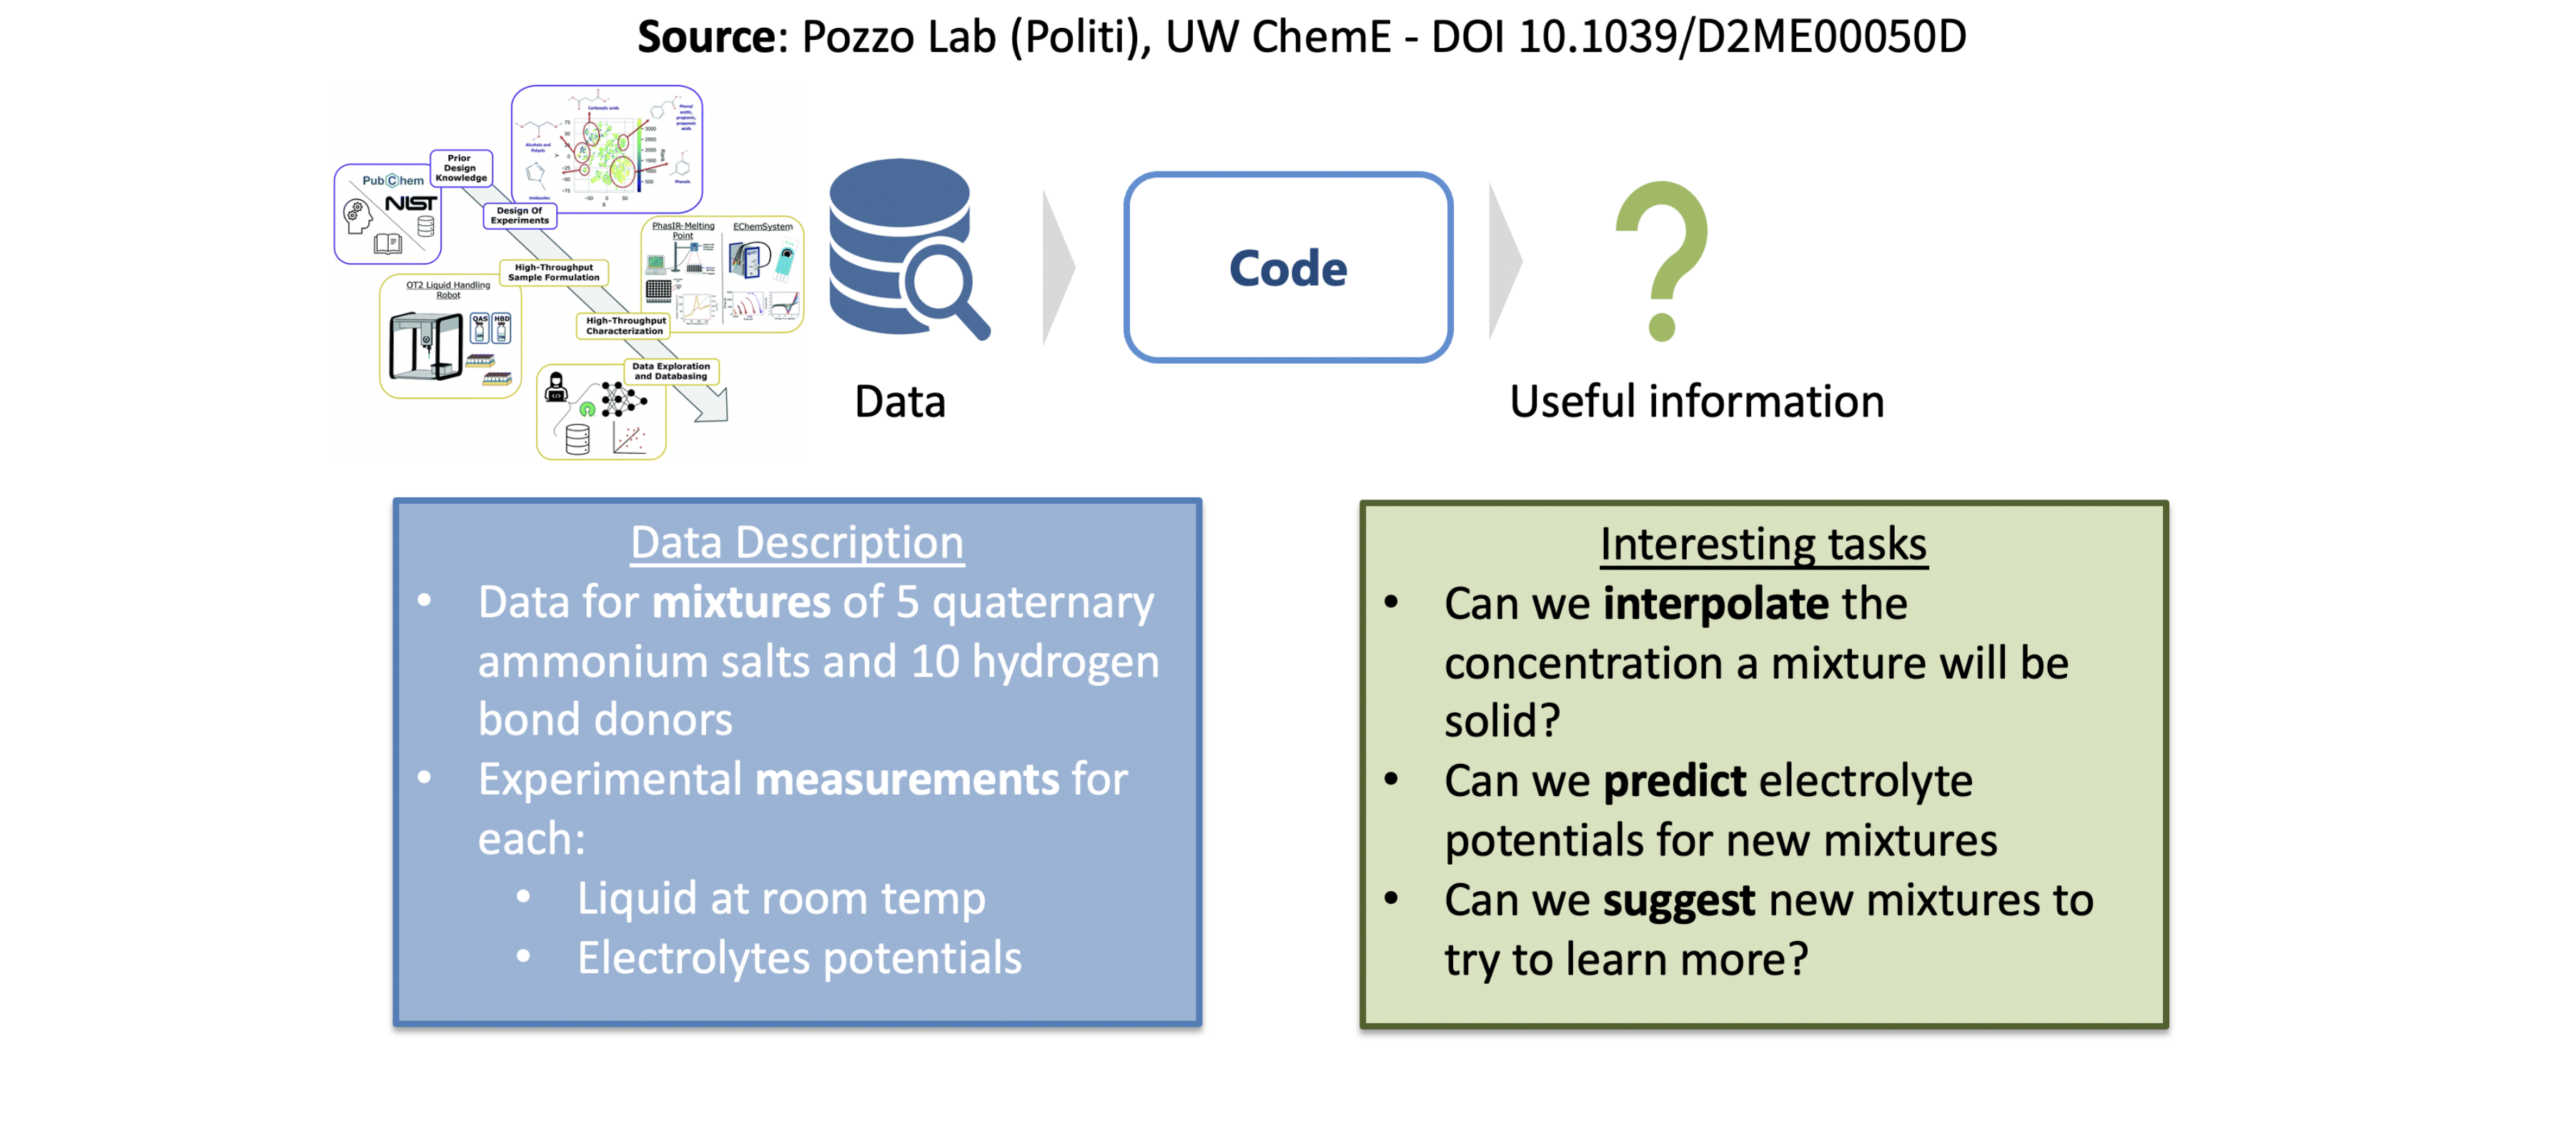

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/UWDIRECT/UWDIRECT.github.io/master/datasets/Politi_DES/politi_des_reformatted.csv', index_col=0)

In [ ]:
df.describe()

<font size=4>Lets say our goal is a __high potential window__ and we want to know about a future HBD or QAS before we buy it. Drop the nans (solids) because we have no potential window measurement for those.

In [ ]:
df=df.dropna()

In [ ]:
df['potential_window'].plot.hist()

***

<font size=4>Remember gaussian process models? They also return prediction standard deviation, eg. uncertainty. __We will use this uncertainty to measure where the model needs to learn more.__

<font size=4>First let's engineer some features.

In [ ]:
names = {
    'Choline Chloride': '[Cl-].OCC[N+](C)(C)C',
    'Acetylcholine Chloride': 'CC(=O)OCC[N+](C)(C)C.[Cl-]',
    'Tetraethylammonium Chloride': 'CC[N+](CC)(CC)CC.[Cl-]',
    'Tetrapropylammonium Bromide': 'CCC[N+](CCC)(CCC)CCC.[Br-]',
    'Tetraethylammonium Iodide': 'CC[N+](CC)(CC)CC.[I-]',
    'Ethylene Glycol': 'OCCO',
    'Glycerol': 'C(C(CO)O)O',
    'Acetamide': 'CC(=O)N',
    'N,N-dimethylurea': 'CNC(=O)NC',
    '3-phenylpropionic acid': 'C1=CC=C(C=C1)CCC(=O)O',
    'Urea': 'C(=O)(N)N',
    'L-serine': 'C(C(C(=O)O)N)O',
    '4-amino triazole': 'C1=NN=CN1N',
    'Xylitol': 'C(C(C(C(CO)O)O)O)O',
    'Phenylacetic acid': 'O=C(O)Cc1ccccc1'
}

In [ ]:
# melting points
mps = {
    'Choline Chloride': 302,
    'Acetylcholine Chloride': 150,
    'Tetraethylammonium Chloride': 360,
    'Tetrapropylammonium Bromide': 286,
    'Tetraethylammonium Iodide': 280,
    'Ethylene Glycol': -12.9,
    'Glycerol': 17.8,
    'Acetamide': 80,
    'N,N-dimethylurea': 183,
    '3-phenylpropionic acid': 48,
    'Urea': 133,
    'L-serine': 222,
    '4-amino triazole': 86,
    'Xylitol': 92,
    'Phenylacetic acid': 256.5
}

<font size=4>Here we will take the maximum potential window observed for a mixture over all mole fractions as the target. Why make this choice?

In [ ]:
df = df.groupby(['QAS', 'HBD']).aggregate(max).reset_index()
df.describe()

<font size=4>29 data points left, eg. 29 unique HBD/QAS combinations

In [ ]:
my_features = ['FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR']
my_calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(my_features)

def smiles_to_descriptors(smiles, calculator=my_calculator):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    descriptors = calculator.CalcDescriptors(mol)
    return descriptors

# features for one compound
# we add the metlting point to the rdkit features
def get_compound_features(name):
    # smiles
    smiles = names.get(name)
    
    # melting point
    mp = mps.get(name)
    
    # start with some rdkit features
    feats = list(smiles_to_descriptors(smiles))
    
    # add the melting point
    feats.append(mp)
    return feats

# get the full feature vector for a HBD/QAS combo
def get_features(hbd, qas):
    hbd_features = get_compound_features(hbd)
    qas_features = get_compound_features(qas)
    features = hbd_features + qas_features
    return features

In [ ]:
X = []
for i, row in df.iterrows():
    X.append(
        get_features(row['HBD'], row['QAS'])
    )
X = np.vstack(X)
print(f"Data X shape: {X.shape}")

<font size=4>43 features... we need to do something about that

In [ ]:
y = df['potential_window'].values.reshape(-1,1)

***

<font size=4>Standardize the data.

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)

<font size=4>PCA to figure out if we can remove any features.

In [ ]:
pca = sklearn.decomposition.PCA(n_components=20)
components = pca.fit_transform(X)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

<font size=4>We only need the first components to completely explain the data.

In [ ]:
X = components[:,:10]

***

<font size=4>Train a GP model

In [ ]:
kernel = sklearn.gaussian_process.kernels.RBF(length_scale=10) + sklearn.gaussian_process.kernels.WhiteKernel()

In [ ]:
model = sklearn.gaussian_process.GaussianProcessRegressor(
    kernel=kernel
)
model.fit(X, y)

***

<font size=4>In comes two new HBDs... which should we select (assume 50/50 ratio with Choline chloride)?

In [ ]:
names['Trifluoroacetic acid'] = 'C(=O)(C(F)(F)F)O'
mps['Trifluoroacetic acid'] = -15.4

In [ ]:
names['Acetanilide'] = 'CC(=O)NC1=CC=CC=C1'
mps['Acetanilide'] = 114

In [ ]:
new_X = np.vstack(
    [
        get_features('Trifluoroacetic acid', 'Choline Chloride'),
        get_features('Acetanilide', 'Choline Chloride')
    ]
)

<font size=4>apply preprocessing...

In [ ]:
new_X = scaler.transform(new_X)
new_X = pca.transform(new_X)
new_X = new_X[:,:10]

<font size=4>Make prediction.

In [ ]:
means, stds = model.predict(new_X, return_std=True)

In [ ]:
print(f"Predicted windows for T. acid and Acetanilide: {means}")
print(f"GP uncertainty for T. acid and Acetanilide: {stds}")

<font size=5><center>The greedy choice is to chose Acetanilide, but the model is more uncertain about T. Acid, so we could learn more by making that sample.

In [ ]:
fig, ax = plt.subplots()
ax.barh(y=['Trifluoroacetic acid', 'Acetanilide'], width=means, xerr=stds)
ax.set_xlabel('Potential window')

<font size=4>A rudementary algorithm might be to take whichever choice has the largest prediction __plus__ uncertainty, like so
    
1. Predict mean and standard deviation (uncertainty) and add them up
2. Select the sample with the highest sum to measure. Upon measurement the uncertainty of data in that region __goes down__ so it is less likely to be taken again unless the predicted mean is very high.
3. Repeat. If there is a predicted high performer, eventually we will take enough data in that space that the uncertainty is very low, and some other space with a lower prediction but high uncertainty is selected.

<font size=4>To __ensure__ that the model is actually miximizing the long term reward, we have to be clever. See the above resources.

***

## Summary

- <font size=4> We talked about PCA again and discussed that it is a type of __"dimensionality reduction", which is an unsupervised learning method__.
    
- <font size=4> __We mentioned two other dimensionality reduction methods, MDS and T-SNE.__ T-SNE is really nice for visualization but should not be trusted for quantitative work.
    
- <font size=4> __We introduced clustering, and used one of many clustering techniques - K-Means__. We also showed how one migh try to optimize the K-Means number of clusters
    
- <font size=4> __We introduced rienforcement learning__, where we can guide future sampling/experimentation why considering learning instead of just best performance.
    
- <font size=4> We started a __very rudementary form of rienforcement learning - using GP standard deviations__ to estimate where the model could maximize learning.

## A challenge for you

<font size=4>Write the K-Means algorithm from scratch! Feel free to use online tutorials as a guide. The workflow for the method is again:

1. Randomly assign K centroids
2. Label all data according to centroid with minimum distance
3. Compute new centroids from the labels
4. repeat 2-3 until the centroids stop moving within some tolerance